# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>School of Kinesiology and Exercise Science, Faculty of Medicine, University of Montreal

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2016: 15 participants
project Violon: 10 participants
project Tennis: 16 participants
project Yoann_2015: 22 participants
project Landry2015_2: 11 participants
project Landry2012: 18 participants
project Patrick_2013: 16 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()

dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 01,0.000381
3,Romain2017,0,upper trapezius,test 04,0.000300
4,Romain2017,0,upper trapezius,test 05,0.000348
5,Romain2017,0,upper trapezius,test 06,0.000111
8,Romain2017,0,upper trapezius,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
import altair as alt
from altair import datum
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

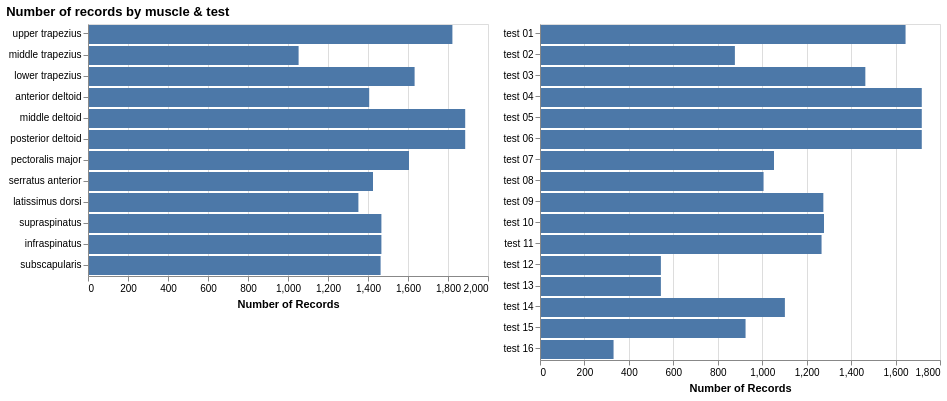

In [7]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar().encode(alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None))
test = base.mark_bar().encode(alt.Y("test", title=None))
(muscle | test).properties(title="Number of records by muscle & test")

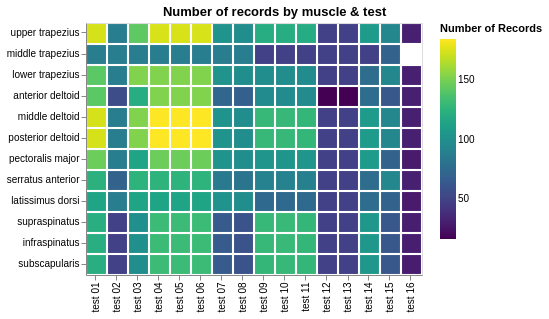

In [8]:
alt.Chart(df_tidy).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    color="count()",
).properties(title="Number of records by muscle & test")

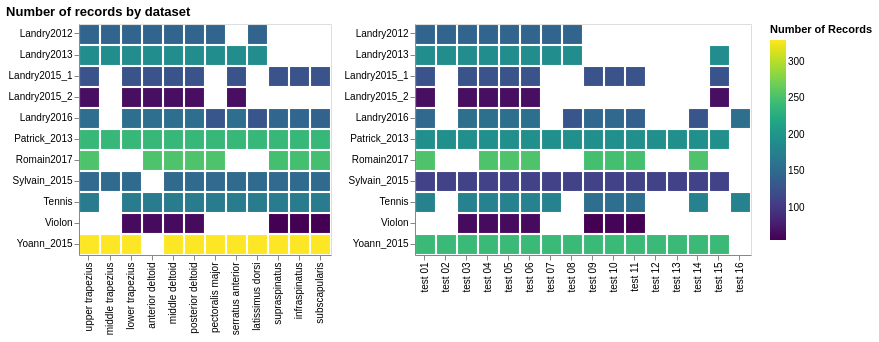

In [9]:
base = alt.Chart(df_tidy).encode(alt.Y("dataset", title=None), color="count()")
test = base.mark_rect().encode(alt.X("test", title=None))
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES), title=None))
(muscle | test).properties(title="Number of records by dataset")

## NaNs count

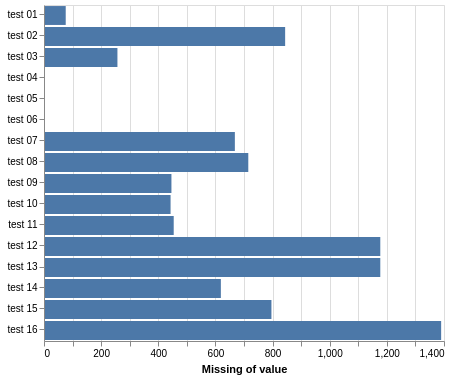

In [10]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar().encode(
    alt.X("missing(value)"), alt.Y("test", title=None)
)

## Which test normalizes which muscle

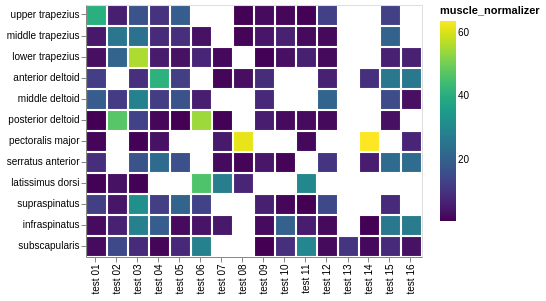

In [11]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer"),
)

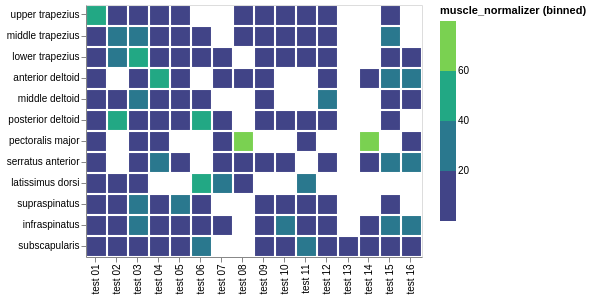

In [12]:
alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer", bin=True),
)

# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

## Normalization

In [13]:
# class Normalize:
#     def __init__(self, ref):
#         self.ref = ref

#     def fit(self, X, y=None):
#         self.ref_vector = X[self.ref]
#         return self

#     def transform(self, X):
#         return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)

#     def fit_transform(self, X, y=None):
#         return self.fit(X).transform(X)

#     def inverse_transform(self, X):
#         return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)

## Split the data

In [14]:
# from sklearn.model_selection import GroupShuffleSplit


# class Pipeline:
#     def __init__(self):
#         pass
    
#     def get_X_and_y(self, d, cols):
#         X = d[cols].dropna(subset=cols)
#         y = d.loc[X.index].select_dtypes(include="float").max(axis=1)
#         p = d["participant"].loc[X.index]

#         # remove the top 2.5 percentile
#         normalized_y = Normalize(ref="test 05").fit(X).transform(y)
#         y = y.loc[normalized_y < normalized_y.quantile(0.975)]
#         return X.loc[y.index], y, p.loc[y.index]

#     @staticmethod
#     def drop_na_rows(d, cols):
#         c = [i for i in cols if i != "muscle"]
#         original_shape = d.shape
#         d = d.dropna(how="all", subset=c)
#         deleted_rows = original_shape[0] - d.shape[0]
#         if deleted_rows != 0:
#             print(f'drop {deleted_rows} NaN rows')
#         return d

#     @staticmethod
#     def split_data(X, y, p, test_size):
#         # we want to make sure that all the data from one participant is in only one set
#         train_id, test_id = next(
#             GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
#                 X, groups=p
#             )
#         )
#         return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


## Evaluation

In [15]:
# from sklearn.metrics import r2_score


# class Evaluate:
#     def __init__(self):
#         pass

#     @staticmethod
#     def mape_vector(y_true, y_pred):
#         return (np.abs((y_true - y_pred) / y_true)) * 100

#     def mape(self, y_true, y_pred):
#         return self.mape_vector(y_true, y_pred).mean()

#     @staticmethod
#     def rmse(y_true, y_pred):
#         val = np.sqrt(((y_pred - y_true) ** 2).mean())
#         return val

#     def report(self, y_true, y_pred):
#         d = {
#             "rmse": self.rmse(y_true, y_pred),
#             "mape": self.mape(y_true, y_pred),
#             "r2": r2_score(y_true, y_pred),
#         }
#         return d


In [16]:
# from xgboost import XGBRegressor
# # from sklearn.linear_model import LinearRegression

# COLS_TO_KEEP = ["test 04", "test 05", "test 06"]
# TEST_SIZE = 0.2
# base_params = {"n_jobs": 1, "silent": True, "random_state": RANDOM_SEED}
# results = {"train": {}, "test": {}}
# index, model, mape_vector = {}, {}, {}

# for imuscle in MUSCLES:
#     subset = df_wide[df_wide["muscle"] == imuscle]
#     pipe = Pipeline()
#     X, y, participants = pipe.get_X_and_y(d=subset, cols=COLS_TO_KEEP)
#     X_train, X_test, y_train, y_test = pipe.split_data(
#         X, y, participants, test_size=0.2
#     )

#     index[imuscle] = {"train": y_train.index, "test": y_test.index}

#     norm_train = Normalize(ref="test 05").fit(X_train)
#     X_train, y_train = (norm_train.transform(X_train), norm_train.transform(y_train))

#     norm_test = Normalize(ref="test 05").fit(X_test)
#     X_test, y_test = norm_test.transform(X_test), norm_test.transform(y_test)

#     fit_params = {
#         "eval_set": [(X_train, y_train), (X_test, y_test)],
#         "early_stopping_rounds": 50,
#         "eval_metric": "rmse",
#         "verbose": None,
#     }

#     model = XGBRegressor(**base_params)
#     model.fit(X_train, y_train, **fit_params)
# #     model = LinearRegression()
# #     model.fit(X_train, y_train)

#     y_pred_train, y_pred_test = (model.predict(X_train), model.predict(X_test))
#     results["train"][imuscle] = Evaluate().report(y_train, y_pred_train)
#     results["test"][imuscle] = Evaluate().report(y_test, y_pred_test)
#     mape_vector[imuscle] = Evaluate().mape_vector(y_test, y_pred_test)

In [17]:
# r = pd.DataFrame()
# for isplit in ["train", "test"]:
#     s = pd.DataFrame(results[isplit]).T.rename_axis("muscle").reset_index()
#     s["split"] = isplit
#     r = pd.concat([r, s])
# print(f"mean for all muscles:\n{r.mean()}")

In [18]:
# alt.Chart(r).mark_bar().encode(
#     alt.X("split", axis=alt.Axis(title="", labels=False, ticks=False, domain=False)),
#     alt.Y("mape"),
#     alt.Color("split"),
#     alt.Column("muscle", sort=MUSCLES, title=None),
# ).properties(width=70)

---

## Bayesian hierarchical linear regression

Having multiple sets of related measurements comes up all the time. In Biomechanics, for example, you test multiple subjects on the same task. 

We then want to estimate a computational/mathematical model that describes the behavior on the task by a set of parameters. We could thus fit a model to each subject individually, assuming they share no similarities; or, pool all the data and estimate one model assuming all subjects are identical.

Hierarchical modeling allows the best of both worlds by modeling subjects’ similarities but also allowing estimiation of individual parameters.

__Benefits of Multilevel Models__
- Accounting for natural hierarchical structure of observational data

- Estimation of coefficients for (under-represented) groups

- Incorporating individual- and group-level information when estimating group-level coefficients

- Allowing for variation among individual-level coefficients across groups

In [19]:
from sklearn.model_selection import GroupShuffleSplit

class Normalize:
    def __init__(self, ref):
        self.ref = ref

    def fit(self, X, y=None):
        self.ref_vector = X[self.ref]
        return self

    def transform(self, X):
        if isinstance(X, pd.core.series.Series):
            return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)
        else:
            X = X.copy()
            num_cols = X.select_dtypes(include="float").columns
            X[num_cols] = (
                X[num_cols].multiply(100, axis=0).divide(self.ref_vector, axis=0)
            )
            return X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)


def get_X_y_p(d, cols):
    X = d[cols].dropna(subset=cols)
    y = d.select_dtypes(include="float").max(axis=1)
    p = d["participant"].iloc[X.index]

    # remove the top 2.5 percentile
    normalized_y = Normalize(ref="test 05").fit(X).transform(y)
    y = y.loc[normalized_y < normalized_y.quantile(0.975)]
    return X.loc[y.index], y, p.loc[y.index]


def split_data(X, y, p, test_size):
    # we want to make sure that all the data from one participant is in only one set
    train_id, test_id = next(
        GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
            X, groups=p
        )
    )
    return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


def mape_vector(y_true, y_pred):
    return (np.abs((y_pred - y_true) / y_true))

In [20]:
# d = {}

# for i in range(10):
#     RANDOM_SEED = i
#     np.random.seed(RANDOM_SEED)

#     COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
#     TEST_SIZE = 0.2

#     X, y, p = get_X_y_p(df_wide, COLS_TO_KEEP)

#     X_train, X_test, y_train, y_test = split_data(X, y, p, test_size=0.2)

#     float_cols = X.select_dtypes(include="float").columns

#     norm_train = Normalize(ref="test 05").fit(X_train)
#     X_train = norm_train.transform(X_train)
#     y_train = norm_train.transform(y_train)

#     norm_test = Normalize(ref="test 05").fit(X_test)
#     X_test = norm_test.transform(X_test)
#     y_test = norm_test.transform(y_test)

#     model = CatBoostRegressor(verbose=False, random_seed=RANDOM_SEED)
#     model.fit(X_train, y_train, cat_features=[0])

#     y_pred_test = model.predict(X_test)

#     d[i] = mape_vector(y_test, y_pred_test).mean()

In [21]:
COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
TEST_SIZE = 0.2

X, y, p = get_X_y_p(df_wide, COLS_TO_KEEP)

X_train, X_test, y_train, y_test = split_data(X, y, p, test_size=0.2)

float_cols = X.select_dtypes(include="float").columns

norm_train = Normalize(ref="test 05").fit(X_train)
X_train = norm_train.transform(X_train)
y_train = norm_train.transform(y_train)

norm_test = Normalize(ref="test 05").fit(X_test)
X_test = norm_test.transform(X_test)
y_test = norm_test.transform(y_test)

In [22]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False, random_seed=RANDOM_SEED)
model.fit(X_train, y_train, cat_features=[0])

In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [24]:
train_eval = (
    mape_vector(y_train, y_pred_train)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_train["muscle"], split="train")
)
test_eval = (
    mape_vector(y_test, y_pred_test)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_test["muscle"], split="test")
)

eval_df = pd.concat([train_eval, test_eval])
eval_df.head()

,mape,muscle,split
0,0.108509,anterior deltoid,train
1,0.016882,latissimus dorsi,train
2,0.091399,lower trapezius,train
3,0.205286,middle deltoid,train
4,0.355257,middle trapezius,train


In [25]:
eval_df.query('split == "test"').mean()

mape    0.195016
dtype: float64

In [26]:
eval_df['mape'].mean()

0.2084800267174536

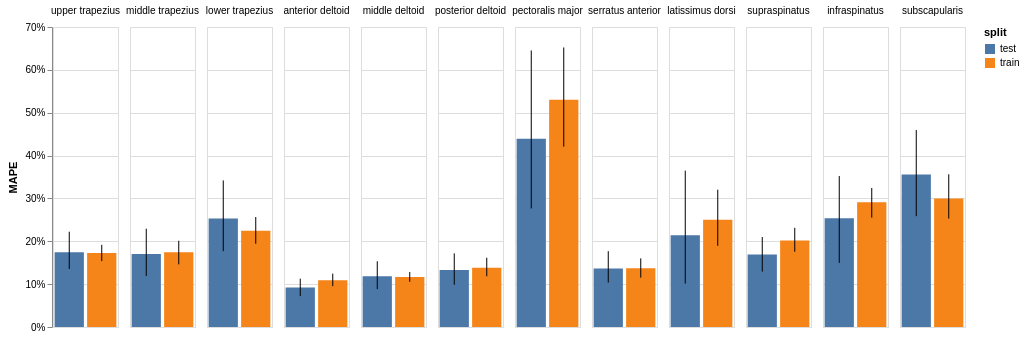

In [27]:
base = (
    alt.Chart()
    .encode(
        alt.X(
            "split",
            title=None,
            axis=alt.Axis(labels=False, domain=False, ticks=False),
            sort=["train", "test"],
        )
    )
    .properties(width=65)
)

bar = base.mark_bar().encode(
    alt.Y("mean(mape)", title="MAPE", axis=alt.Axis(format="%")), alt.Color("split")
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))


(bar + error).facet(data=eval_df, column=alt.Column("muscle", sort=MUSCLES, title=None))

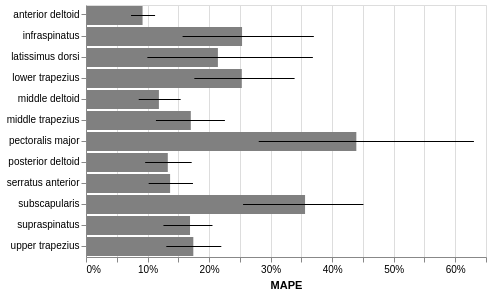

In [28]:
base = alt.Chart(test_eval).encode(alt.Y("muscle", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

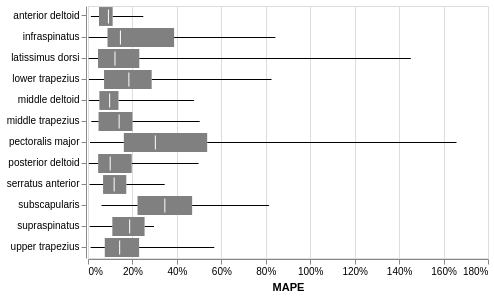

In [29]:
base = alt.Chart().encode(alt.Y("muscle", sort=MUSCLES, title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))
upper = base.mark_rule().encode(alt.X("q3(mape)"), alt.X2("max(mape)"))
med = base.mark_tick(color='white').encode(alt.X("median(mape)"))

(upper + bar + med + lower).facet(data=test_eval)

# Part 4: Comparison with other studies

In [30]:
import pickle

RECOMMANDATIONS_PATH = MODEL_PATH / "recommandations.pkl"
if RECOMMANDATIONS_PATH.is_file():
    with open(RECOMMANDATIONS_PATH, "rb") as h:
        recommandations = pickle.load(h)
else:
    recommandations = {}

## Boettcher et al., 2008

[Boettcher et al., 2008](https://onlinelibrary.wiley.com/doi/abs/10.1002/jor.20675) identified a unique combinations of 4 MVIC tests to normalize 12 shoulder muscles

In [31]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["NT4"] = {
        i: ["test 12", "test 13", "test 14", "test 15"] for i in MUSCLES
    }

## Dal Maso et al., 2016

[Dal Maso et al., 2016](https://www.sciencedirect.com/science/article/pii/S0003999316000307)

### As published

In [32]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["DM"] = {
        "upper trapezius": ["test 01", "test 03", "test 05", "test 12"],
        "middle trapezius": [
            "test 02",
            "test 03",
            "test 08",
            "test 10",
            "test 12",
            "test 15",
        ],
        "lower trapezius": ["test 02", "test 03", "test 05", "test 11", "test 15"],
        "anterior deltoid": ["test 04", "test 05", "test 09", "test 12"],
        "middle deltoid": ["test 03", "test 09", "test 12", "test 15"],
        "posterior deltoid": ["test 02", "test 06"],
        "pectoralis major": ["test 08", "test 14"],
        "serratus anterior": ["test 03", "test 05", "test 07", "test 14", "test 15"],
        "latissimus dorsi": ["test 06", "test 07", "test 08", "test 11"],
        "supraspinatus": ["test 01", "test 03", "test 05", "test 12"],
        "infraspinatus": ["test 02", "test 03", "test 04", "test 15"],
        "subscapularis": [
            "test 02",
            "test 03",
            "test 06",
            "test 10",
            "test 11",
            "test 15",
        ],
    }

### Implemented on our data

In [33]:
def compute_criterion(d, sets, thr):
    proportion = np.ones((sets.shape[0]))
    for i, iset in enumerate(sets):
        maximal_above_thr = d[iset].max(axis=1) > d.max(axis=1) * (thr / 100)
        proportion[i] = maximal_above_thr.sum() / d.shape[0] * 100

    sorted_idx = np.argsort(proportion)
    best_set = sets[sorted_idx][-1]
    best_proportion = proportion[sorted_idx][-1]
    return best_set, best_proportion

In [34]:
from itertools import combinations

THRESHOLD = 90
PERCENTILE = 90
TESTS = [i for i in df_wide.columns if i[:4] == "test"]

if RECOMMANDATIONS_PATH.is_file():
    print(recommandations["DM updated"])
else:
    recommandations["DM updated"] = {}
    for imuscle in MUSCLES:
        X_train_comp = df_wide.loc[X_train.index].query("muscle == @imuscle")[TESTS]
        print(f"{imuscle.upper()} ({X_train_comp.shape[0]} points)")

        for ntests in range(1, len(TESTS) + 1):
            sets = np.array(list(combinations(TESTS, ntests)))
            best_set, best_proportion = compute_criterion(X_train_comp, sets, thr=THRESHOLD)

            if best_proportion > PERCENTILE:
                print(f"\tno. of tests: {ntests}")
                print(f"\tbest set: {best_set}")
                print(f"\tproportion: {best_proportion:.2f}")
                print("-" * 10)
                recommandations["DM updated"][imuscle] = best_set
                break
    with open(RECOMMANDATIONS_PATH, "wb") as h:
        pickle.dump(recommandations, h)

{'upper trapezius': array(['test 01', 'test 03', 'test 05'], dtype='<U7'), 'middle trapezius': array(['test 02', 'test 03', 'test 05', 'test 09', 'test 10', 'test 15'],
      dtype='<U7'), 'lower trapezius': array(['test 02', 'test 03', 'test 04', 'test 06', 'test 15'], dtype='<U7'), 'anterior deltoid': array(['test 03', 'test 04', 'test 05', 'test 09', 'test 15', 'test 16'],
      dtype='<U7'), 'middle deltoid': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'posterior deltoid': array(['test 02', 'test 03', 'test 06'], dtype='<U7'), 'pectoralis major': array(['test 08', 'test 14'], dtype='<U7'), 'serratus anterior': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'latissimus dorsi': array(['test 06', 'test 07', 'test 11'], dtype='<U7'), 'supraspinatus': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 09'], dtype='<U7'), 'infraspinatus': array(['test 03', 'test 04', 'test 06', 'test 10', 'test 11', 'test 15'],
      dt

## Compare Boettcher & Dal Maso with our model

### MAPE for each method

In [35]:
test_comparison = df_wide.drop(["dataset", "participant"], axis=1).loc[X_test.index]

r = []
for imuscle in MUSCLES:
    current = test_comparison.query("muscle == @imuscle").drop("muscle", axis=1)
    for imethod in recommandations.keys():
        r.append(
            mape_vector(
                current.max(axis=1),
                current[recommandations[imethod][imuscle]].max(axis=1),
            )
            .rename("mape")
            .to_frame()
            .assign(method=imethod, muscle=imuscle)
        )

df_comp = pd.concat(
    r + [test_eval.drop("split", axis=1).assign(method="ML3")], sort=False
)

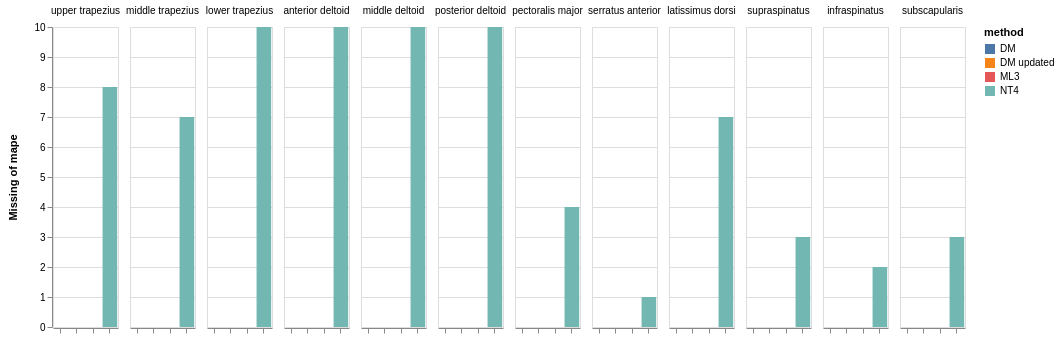

In [36]:
alt.Chart(df_comp).mark_bar().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False)),
    alt.Y("missing(mape)"),
    alt.Color("method"),
    alt.Column("muscle", sort=MUSCLES, title=None),
).properties(width=65)

### Non-parametric stats

In [37]:
from sklearn.impute import SimpleImputer
import spm1d

ALPHA = 0.05
N_ITER = 10000
p_value = {}

for imethod in combinations(set(df_comp["method"].unique()), 2):
    print(f"{imethod[0].upper()} vs. {imethod[1].upper()}")
    p_value[imethod] = {}
    for imuscle in MUSCLES:

        a = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[0]}"')[
            "mape"
        ].values.reshape(-1, 1)
        b = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[1]}"')[
            "mape"
        ].values.reshape(-1, 1)

        a = SimpleImputer(strategy="median").fit_transform(a)
        b = SimpleImputer(strategy="median").fit_transform(b)

        ttest = spm1d.stats.nonparam.ttest_paired(a.ravel(), b.ravel())
        ttesti = ttest.inference(alpha=ALPHA, iterations=N_ITER, two_tailed=True)

        if ttesti.h0reject:
            direction = ">" if a.mean() > b.mean() else "<"
            string = f"{imethod[0]} {direction} {imethod[1]}"
            p_value[imethod][imuscle] = ttesti.p
        else:
            string = "no differences"
            p_value[imethod][imuscle] = np.nan

        print(f"\t{imuscle}: {string}")

ML3 vs. NT4
	upper trapezius: ML3 < NT4
	middle trapezius: no differences
	lower trapezius: ML3 < NT4
	anterior deltoid: ML3 < NT4
	middle deltoid: ML3 < NT4
	posterior deltoid: ML3 < NT4
	pectoralis major: no differences
	serratus anterior: no differences
	latissimus dorsi: ML3 < NT4
	supraspinatus: ML3 < NT4
	infraspinatus: no differences
	subscapularis: ML3 < NT4
ML3 vs. DM UPDATED
	upper trapezius: ML3 > DM updated
	middle trapezius: ML3 > DM updated
	lower trapezius: ML3 > DM updated
	anterior deltoid: ML3 > DM updated
	middle deltoid: ML3 > DM updated
	posterior deltoid: ML3 > DM updated
	pectoralis major: ML3 > DM updated
	serratus anterior: ML3 > DM updated
	latissimus dorsi: ML3 > DM updated
	supraspinatus: ML3 > DM updated
	infraspinatus: ML3 > DM updated
	subscapularis: ML3 > DM updated
ML3 vs. DM
	upper trapezius: ML3 > DM
	middle trapezius: ML3 > DM
	lower trapezius: ML3 > DM
	anterior deltoid: ML3 > DM
	middle deltoid: no differences
	posterior deltoid: ML3 > DM
	pectoral

/home/romain/miniconda3/envs/mvc/lib/python3.7/site-packages/spm1d/stats/nonparam/calculators.py:34: RuntimeWarning: invalid value encountered in double_scalars
  return y.mean(axis=0) / (  y.std(axis=0, ddof=1) / self.sqrtN  )
/home/romain/miniconda3/envs/mvc/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/romain/miniconda3/envs/mvc/lib/python3.7/site-packages/spm1d/stats/nonparam/permuters.py:48: RuntimeWarning: invalid value encountered in less
  p     = 2 * ( self.Z < z ).mean()


	pectoralis major: no differences
	serratus anterior: no differences
	latissimus dorsi: no differences
	supraspinatus: no differences
	infraspinatus: no differences
	subscapularis: no differences


In [40]:
p = pd.DataFrame(p_value).T.reset_index()
p = (
    p.set_index(p["level_0"] + " vs " + p["level_1"])
    .drop(["level_0", "level_1"], axis=1)
    .T
)
p

,ML3 vs NT4,ML3 vs DM updated,ML3 vs DM,NT4 vs DM updated,NT4 vs DM,DM updated vs DM
anterior deltoid,0.0142,0.0001,0.0040,0.0001,0.0030,0.0001
infraspinatus,NaN,0.0046,NaN,0.0002,0.0016,NaN
latissimus dorsi,0.0012,0.0001,0.0001,0.0001,0.0001,NaN
lower trapezius,0.0024,0.0001,0.0001,0.0001,0.0001,NaN
middle deltoid,0.0002,0.0002,NaN,0.0001,0.0001,0.0082
middle trapezius,NaN,0.0001,0.0001,0.0001,0.0001,NaN
pectoralis major,NaN,0.0001,0.0001,0.0001,0.0001,NaN
posterior deltoid,0.0001,0.0001,0.0001,0.0001,0.0001,NaN
serratus anterior,NaN,0.0008,0.0064,0.0002,0.0002,NaN
subscapularis,0.0054,0.0004,0.0012,0.0001,0.0002,NaN


In [41]:
pd.cut(
    p.stack(),
    bins=[-np.inf, 0.0001, 0.001, 0.01, 0.05, np.inf],
    labels=["****", "***", "**", "*", "ns"],
).unstack()

,ML3 vs NT4,ML3 vs DM updated,ML3 vs DM,NT4 vs DM updated,NT4 vs DM,DM updated vs DM
anterior deltoid,*,****,**,****,**,****
infraspinatus,NaN,**,NaN,***,**,NaN
latissimus dorsi,**,****,****,****,****,NaN
lower trapezius,**,****,****,****,****,NaN
middle deltoid,***,***,NaN,****,****,**
middle trapezius,NaN,****,****,****,****,NaN
pectoralis major,NaN,****,****,****,****,NaN
posterior deltoid,****,****,****,****,****,NaN
serratus anterior,NaN,***,**,***,***,NaN
subscapularis,**,***,**,****,***,NaN


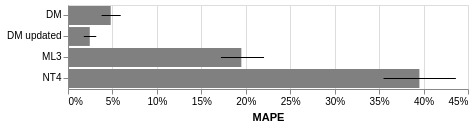

In [44]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

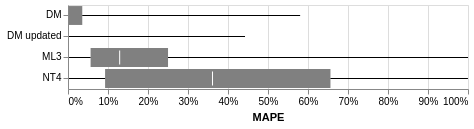

In [45]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
med = base.mark_tick(color="white").encode(alt.X("median(mape)"))
upper = base.mark_rule().encode(
    alt.X("q3(mape)", scale=alt.Scale(domain=[0, 1], clamp=True)), alt.X2("max(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))


bar + med + upper + lower

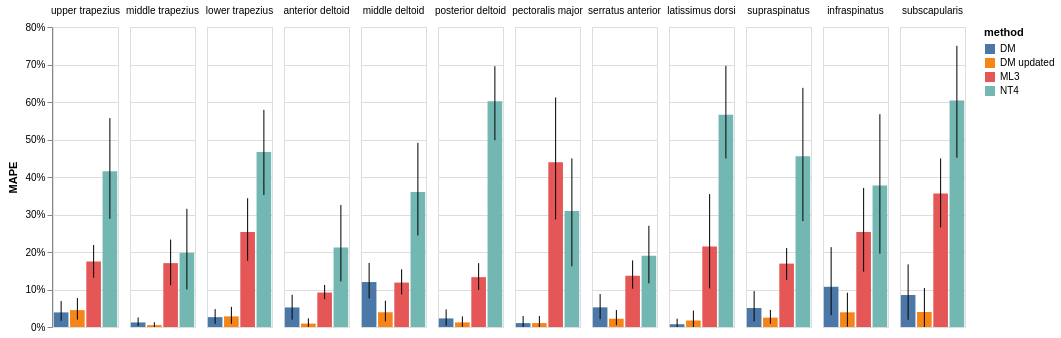

In [46]:
base = alt.Chart().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False, ticks=False, domain=False))
)


bar = base.mark_bar().encode(
    alt.Y("mean(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.Color("method")
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))

(bar.properties(width=65) + error).facet(data=df_comp, column=alt.Column("muscle", sort=MUSCLES, title=None))

### Compare execution time

In [47]:
30/12

2.5

In [59]:
time

{'NT4': 4, 'DM': 14, 'DM updated': 14}

In [148]:
time_by_test = 2.5  # min
time = {}
for imethod in recommandations.keys():
    c = []
    for imuscle, tests in recommandations[imethod].items():
        for itest in tests:
            if itest not in c:
                c.append(itest)
    time[imethod] = time_by_test * len(c)
time["ML3"] = time_by_test * 3
time = pd.Series(time).rename("execution time (min)").rename_axis("method").reset_index()

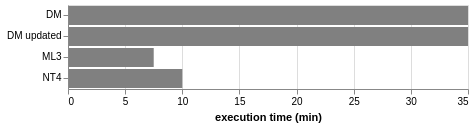

In [149]:
alt.Chart(time).mark_bar(color="grey").encode(
    alt.X("execution time (min)"), alt.Y("method", title=None)
)

In [231]:
scatter_df = (
    df_comp.groupby("method")["mape"].mean().reset_index().merge(time, on="method")
).assign(
    dist_from_0=lambda x: np.sqrt(
        (x["mape"].multiply(100).pow(2) + x["execution time (min)"].pow(2))
    ).round(2)
)

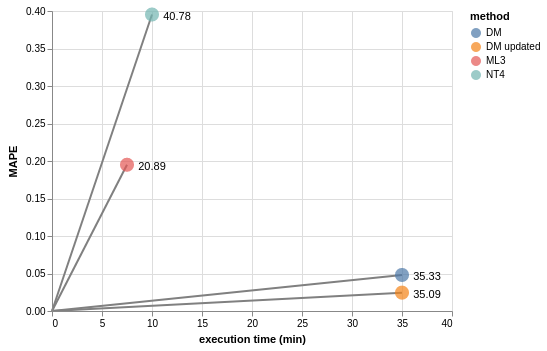

In [239]:
scatter = (
    alt.Chart(scatter_df)
    .mark_circle(size=200)
    .encode(
        alt.X("execution time (min)", scale=alt.Scale(domain=[0, 40])), alt.Y("mape", title="MAPE"), alt.Color("method")
    )
)

text = (
    alt.Chart(scatter_df)
    .mark_text(dx=25, dy=5)
    .encode(
        alt.X("execution time (min)"), alt.Y("mape"), alt.Text('dist_from_0')
    )
)

dist_rule = (
    alt.Chart(
        pd.concat(
            [scatter_df, scatter_df.assign(**{"mape": 0, "execution time (min)": 0})]
        )
    )
    .mark_line(color='grey')
    .encode(alt.X("execution time (min)"), alt.Y("mape"), alt.Detail("method"))
)

dist_rule + scatter + text